## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

In [1]:
pip install -U scikit-learn --user

Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


# 1. Подготовка

In [5]:
                                 import pandas as pd
                                 import seaborn as sns
                                 import numpy as np
from datetime                    import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection     import TimeSeriesSplit


from sklearn.model_selection     import train_test_split

from statsmodels.tsa.holtwinters import ExponentialSmoothing , SimpleExpSmoothing , Holt
from statsmodels.tsa.seasonal    import seasonal_decompose

from sklearn.linear_model        import LinearRegression
from sklearn.tree                import DecisionTreeRegressor 
from sklearn.ensemble            import RandomForestRegressor
from sklearn.metrics             import *



# 2. Анализ

In [3]:
df_taxi = pd.read_csv('/datasets/taxi.csv' , index_col=[0], parse_dates=[0])

In [4]:
df_taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# Ресемплирование значений
df_taxi_hour=df_taxi.resample('1H').sum()

df_taxi_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df_taxi_hour.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


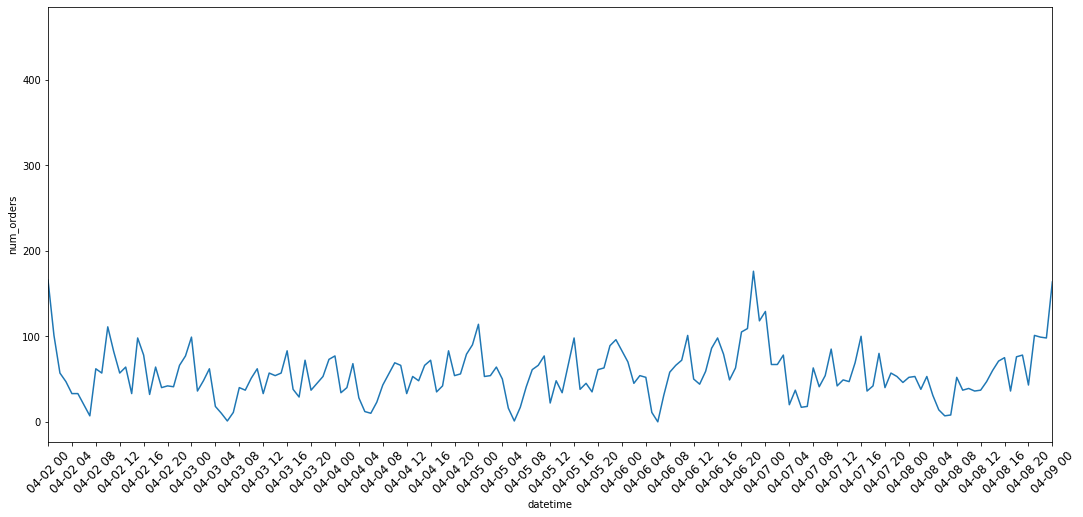

In [8]:
#График значений во времени
# Скользящее среднее
rolling_mean = df_taxi_hour['num_orders'].shift().rolling(24).mean()

# Задаем границы графика
start = '2018-04-02 00:00:00'
end = '2018-04-09 00:00:00'

# Строим график
plt.figure(figsize = (18,8))

ax = sns.lineplot(x = df_taxi_hour.index , y = df_taxi_hour['num_orders']  );
xplot = ax.get_xticklabels()
ax.set_xlim(start , end)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.xticks(rotation=45 , fontsize = 12)

plt.show()

In [9]:
# Создаем новые признаки
def new_features(data , lag , rolling_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1,lag+1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    
    data['is_weekend'] = data.index.dayofweek.isin([5,6])*1
    return data.dropna()

In [29]:
df_taxi_final = new_features(df_taxi_hour,24,3)
df_taxi_final.head(5)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,79.000000,0
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,87.000000,0
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.333333,0
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,95.000000,0
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.333333,0


### Вывод:
- данные ресмеплированы с шагом один час.
- построен часовой график количества вызовов с в предалах одной недели.
- на графике видна "сезонность", определяемая временем суток. Отчетливовидно снижение количества заказов в после 0 до 2 часов ночи, и повышение с 3 до 9 часов утра. Также хорошо заметен пик значений в пятницу вечером.
- в датасет добавлены новые фичи: полученные из даты день недели, месяц и т.д. , значения целевой переменной с задержкой от 1 до 24 часов, и значения скользящей средней.



# 3. Обучение

In [11]:
# Разбиваем датасет на признаки
def train_test(data):

    # Выделяем признаки
    X = data.drop(['num_orders'] , axis=1)
    y = data['num_orders']

    # Выделяем обучающую и тестовую выборки
    X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.1 , shuffle = False)
    
    return {'X_train': X_train , 'X_test': X_test , 'y_train': y_train , 'y_test': y_test}   

In [12]:
# Обучающие признаки
X_train = train_test(df_taxi_final)['X_train']
y_train = train_test(df_taxi_final)['y_train']

X_train.shape , y_train.shape

((3952, 30), (3952,))

In [13]:
# RMSE для оценки качества
def RMSE(y , y_pred):
    return mean_squared_error(y , y_pred , squared=False)
rmse = make_scorer(RMSE , greater_is_better=True)

### Random forest time series CV

In [14]:
def RF_timeseriesCVscore(X , y):
    # вектор ошибок
    errors = []
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=5) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, valid in tscv.split(X.values):
        X_train , X_test = X.values[train] , X.values[valid]
        y_train , y_test = y.values[train] , y.values[valid]
        
        model = RandomForestRegressor(random_state=12, n_estimators=100 , max_depth=10)
        model.fit(X_train , y_train)

        y_pred = model.predict(X_test)
        
        error = RMSE(y_test, y_pred)
        errors.append(error)

    # Возвращаем среднее значение ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [15]:
print('RMSE mean Random Forest:' , RF_timeseriesCVscore(X_train , y_train))

RMSE mean Random Forest: 25.482435858530152


### Linear regression time series CV

In [16]:
def LM_timeseriesCVscore(X , y):
    # вектор ошибок
    errors = []
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=6) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, valid in tscv.split(X.values):
        X_train , X_test = X.values[train] , X.values[valid]
        y_train , y_test = y.values[train] , y.values[valid]
        
        model = LinearRegression()
        model.fit(X_train , y_train)

        y_pred = model.predict(X_test)
        
        error = RMSE(y_test, y_pred)
        errors.append(error)

    # Возвращаем среднее значение ошибки по вектору ошибок 
    return  np.mean(np.array(errors))

In [17]:
print('RMSE mean Linear model:' , LM_timeseriesCVscore(X_train , y_train))

RMSE mean Linear model: 26.798768172423262


### Holt-Winters time series CV

In [18]:
df_taxi_hour=df_taxi.resample('1H').sum()

hw_train , hw_test = train_test_split(df_taxi_hour , test_size = 0.1 , shuffle = False , random_state = 12)
hw_train.shape , hw_test.shape

((3974, 1), (442, 1))

In [19]:
def HW_timeseriesCVscore(data):
    # вектор ошибок
    errors = []
    
    values = data.values
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=10) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, valid in tscv.split(values):
        
        
        model = ExponentialSmoothing(values[train],  trend = 'add' , seasonal_periods=12 , seasonal='add' )
        fit = model.fit(smoothing_level =0.1  , smoothing_slope = 0)

        predictions = fit.forecast(len(valid))
        
        error = RMSE(values[valid], predictions)
        errors.append(error)

    # Возвращаем среднее значение ошибки по вектору ошибок 
    return np.mean(np.array(errors))


In [20]:
print('RMSE mean Holt_Winters model:' , HW_timeseriesCVscore(hw_train))

RMSE mean Holt_Winters model: 38.81542571420883


### Вывод:
- для прогнозирования заказов применены 3 модели: случайный лес, линейная регрессия и модель Хольта-Винтерса.
- для корректной кроссвалидации применен метод библиотеки scikit learn TimeSeriesSplit().
- на кросс-валидации лучший результат показывает модель Random Forest. Хуже всех модель Хольта-Винтерса.


# 4. Тестирование

In [21]:
# Тестовые признаки
X_test = train_test(df_taxi_final)['X_test']
y_test = train_test(df_taxi_final)['y_test']

X_test.shape , y_test.shape

((440, 30), (440,))

In [22]:
# График предсказаний
def plot_pred(train , test , pred , model):
    pred = pd.Series(pred , index = test.index)
    
    # Задаем границы графика
    start = train.index[-len(test)]
    end = test.index[-1]
    
    plt.figure(figsize=(16,8))
    plt.plot( train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(pred, label=model)
    plt.xlim(start , end)
    plt.legend(loc='best')
    plt.show()

### Random forest test


In [23]:
rf_model = RandomForestRegressor(random_state=12, n_estimators=100 , max_depth=10)
rf_model.fit(X_train , y_train)

y_pred_rf = rf_model.predict(X_test)

print('RMSE mean Random forest test:' , RMSE(y_test , y_pred_rf))


RMSE mean Random forest test: 43.78340939360335


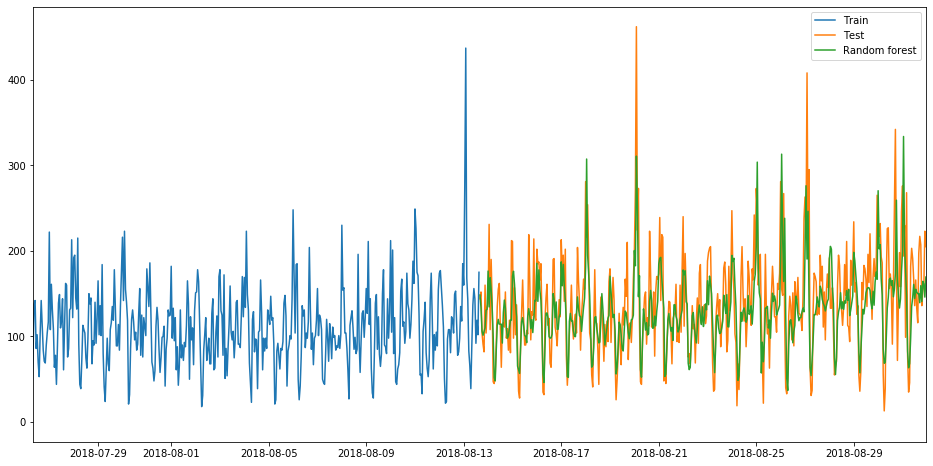

In [24]:
plot_pred(y_train , y_test , y_pred_rf , 'Random forest')

### Linear regression test

In [25]:
lm_model = LinearRegression()
lm_model.fit(X_train , y_train)

y_pred_lm = lm_model.predict(X_test)

print('RMSE mean Linear regression test:' , RMSE(y_test , y_pred_lm))


RMSE mean Linear regression test: 45.634227063556445


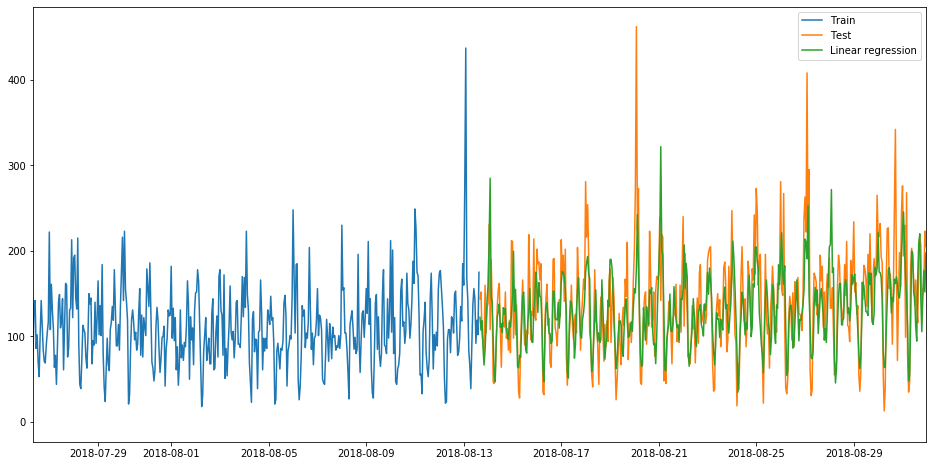

In [26]:
plot_pred(y_train , y_test , y_pred_lm , 'Linear regression')

### Holt-Winters test

In [27]:
hw_model = ExponentialSmoothing(hw_train.values , trend = 'add' , seasonal_periods=24 , seasonal='add')
fit = hw_model.fit(smoothing_level =0.1  , smoothing_slope = 0.148 , remove_bias = True)

hw_test['holt_winter'] = fit.forecast(len(hw_test))
        
RMSE(hw_test['num_orders'], hw_test['holt_winter'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


54.90036227920499

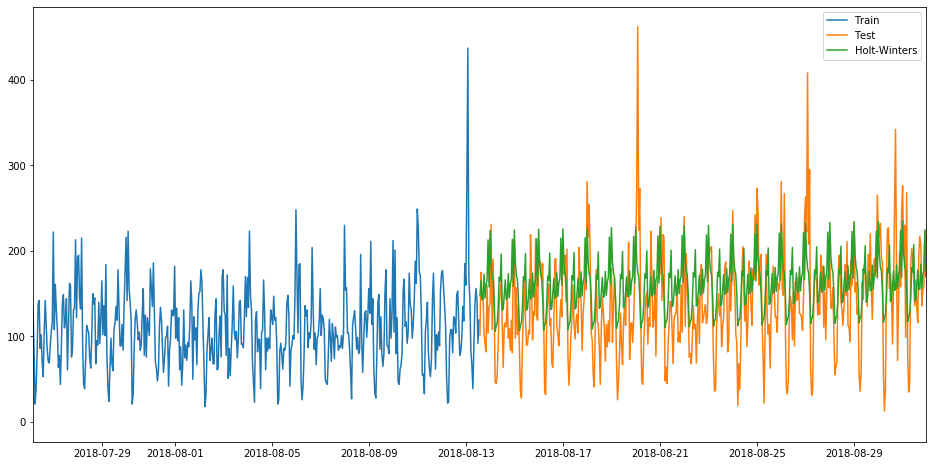

In [28]:
plot_pred(hw_train , hw_test['num_orders'] , hw_test['holt_winter'] , 'Holt-Winters')

### Вывод:
- на тестовых данных лучший результат показывает модель Random Forest. 
- при ручном подборе параметров модели Холта-Винтерса результат не меняется в лучшую сторону.
В итоге принимаем модель Random Forest с результатом **RMSE 43.78**

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

In [1]:
dict = {'a':1 , 'b':2 , 'd':3}

In [7]:
a = np.array(dict.items())

In [8]:
a

array(dict_items([('a', 1), ('b', 2), ('d', 3)]), dtype=object)